<a href="https://colab.research.google.com/github/Chakleston/Git_test/blob/main/analisis_marketing_negocio.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Se pidió en éste proyecto comparar 10 fuentes de adquisición, para poder ver cual daba el mejor Retorno de Inversión, para ésto se usaran tres tablas distintas para poder sacar la vida útil de los clientes (LTV) y el costo de adquisición por cliente (CAC) y posteriormente el ROMI.


# Preprocesamiento

## Cargar librerias.

In [1]:

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
pd.set_option('display.max_columns', None)

## Cargar datos.

In [2]:
costs = pd.read_csv('/costs_us.csv')
orders = pd.read_csv('/orders_log_us.csv')
visits = pd.read_csv('/visits_log_us.csv')

## Ver Información

In [3]:
visits.info(memory_usage='deep')
print(' ')
orders.info(memory_usage='deep')
print(' ')
costs.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   Device     359400 non-null  object
 1   End Ts     359400 non-null  object
 2   Source Id  359400 non-null  int64 
 3   Start Ts   359400 non-null  object
 4   Uid        359400 non-null  uint64
dtypes: int64(1), object(3), uint64(1)
memory usage: 79.3 MB
 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Buy Ts   50415 non-null  object 
 1   Revenue  50415 non-null  float64
 2   Uid      50415 non-null  uint64 
dtypes: float64(1), object(1), uint64(1)
memory usage: 4.4 MB
 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  

No hay valores nulos, pero se tiene que formatear el estilo, la fecha y renombrar columnas.

### Visits

In [4]:
visits['End Ts'] = pd.to_datetime(visits['End Ts'], format = '%Y-%m-%d %H:%M:%S')
visits['Start Ts'] = pd.to_datetime(visits['Start Ts'], format = '%Y-%m-%d %H:%M:%S')

In [5]:
visits

,Device,End Ts,Source Id,Start Ts,Uid
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168
...,...,...,...,...,...
359395,desktop,2017-07-29 19:07:19,2,2017-07-29 19:07:00,18363291481961487539
359396,touch,2018-01-25 17:38:19,1,2018-01-25 17:38:00,18370831553019119586
359397,desktop,2018-03-03 10:12:19,4,2018-03-03 10:12:00,18387297585500748294
359398,desktop,2017-11-02 10:12:19,5,2017-11-02 10:12:00,18388616944624776485


Renombrar Columnas

In [6]:
visits = visits.rename(columns={'Device':'device', 'End Ts':'final_sesion_ts', 'Source Id':'source_id', 'Start Ts':'inicio_sesion_ts', 'Uid':'uid'})

In [7]:
visits.value_counts('device')

,count
device,
desktop,262567
touch,96833


In [8]:
visits.value_counts('source_id')

,count
source_id,
4,101794
3,85610
5,66905
2,47626
1,34121
9,13277
10,10025
7,36
6,6


Hay varias fuentes que no proveen muchos clientes, la fuente 6 y 7 y la 8 no aparece siquiera.

In [9]:
print('primeros de inicios de sesion', visits['inicio_sesion_ts'].min())
print('últimos de inicios de sesion',visits['inicio_sesion_ts'].max())



primeros de inicios de sesion 2017-06-01 00:01:00
últimos de inicios de sesion 2018-05-31 23:59:00


In [10]:
print('primeros de cierres de sesion', visits['final_sesion_ts'].min())
print('últimos de cierres de sesion',visits['final_sesion_ts'].max())

primeros de cierres de sesion 2017-06-01 00:02:00
últimos de cierres de sesion 2018-06-01 01:26:00


In [11]:
# revisión de ausentes
visits.isna().sum()

,0
device,0
final_sesion_ts,0
source_id,0
inicio_sesion_ts,0
uid,0


Tenemos un año de información, sólo un día en el último mes.

### Orders

In [12]:
orders

,Buy Ts,Revenue,Uid
0,2017-06-01 00:10:00,17.00,10329302124590727494
1,2017-06-01 00:25:00,0.55,11627257723692907447
2,2017-06-01 00:27:00,0.37,17903680561304213844
3,2017-06-01 00:29:00,0.55,16109239769442553005
4,2017-06-01 07:58:00,0.37,14200605875248379450
...,...,...,...
50410,2018-05-31 23:50:00,4.64,12296626599487328624
50411,2018-05-31 23:50:00,5.80,11369640365507475976
50412,2018-05-31 23:54:00,0.30,1786462140797698849
50413,2018-05-31 23:56:00,3.67,3993697860786194247


In [13]:
orders['Buy Ts'] = pd.to_datetime(orders['Buy Ts'], format = '%Y-%m-%d %H:%M:%S')

In [14]:
orders = orders.rename(columns={'Buy Ts':'tiempo_de_compra','Revenue':'ingreso',	'Uid':'uid'})

In [15]:
orders

,tiempo_de_compra,ingreso,uid
0,2017-06-01 00:10:00,17.00,10329302124590727494
1,2017-06-01 00:25:00,0.55,11627257723692907447
2,2017-06-01 00:27:00,0.37,17903680561304213844
3,2017-06-01 00:29:00,0.55,16109239769442553005
4,2017-06-01 07:58:00,0.37,14200605875248379450
...,...,...,...
50410,2018-05-31 23:50:00,4.64,12296626599487328624
50411,2018-05-31 23:50:00,5.80,11369640365507475976
50412,2018-05-31 23:54:00,0.30,1786462140797698849
50413,2018-05-31 23:56:00,3.67,3993697860786194247


In [16]:
# revisión de ausentes
orders.isna().sum()

,0
tiempo_de_compra,0
ingreso,0
uid,0


### Costs

In [17]:
costs

,source_id,dt,costs
0,1,2017-06-01,75.20
1,1,2017-06-02,62.25
2,1,2017-06-03,36.53
3,1,2017-06-04,55.00
4,1,2017-06-05,57.08
...,...,...,...
2537,10,2018-05-27,9.92
2538,10,2018-05-28,21.26
2539,10,2018-05-29,11.32
2540,10,2018-05-30,33.15


In [18]:
costs['dt'] = pd.to_datetime(costs['dt'])
costs

,source_id,dt,costs
0,1,2017-06-01,75.20
1,1,2017-06-02,62.25
2,1,2017-06-03,36.53
3,1,2017-06-04,55.00
4,1,2017-06-05,57.08
...,...,...,...
2537,10,2018-05-27,9.92
2538,10,2018-05-28,21.26
2539,10,2018-05-29,11.32
2540,10,2018-05-30,33.15


In [19]:
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   source_id  2542 non-null   int64         
 1   dt         2542 non-null   datetime64[ns]
 2   costs      2542 non-null   float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 59.7 KB


In [20]:
print('primer gasto', costs['dt'].min())
print('ultimo gasto', costs['dt'].max())

primer gasto 2017-06-01 00:00:00
ultimo gasto 2018-05-31 00:00:00


# Métricas; Visitas, Ventas y Marketing.

## Visitas

In [21]:
visits.head()

,device,final_sesion_ts,source_id,inicio_sesion_ts,uid
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168


In [22]:
visits['sesion_mes'] =  visits['inicio_sesion_ts'].dt.month
visits['sesion_semana'] =  visits['inicio_sesion_ts'].dt.isocalendar().week
visits['sesion_fecha'] =  visits['inicio_sesion_ts'].dt.date
visits.head()

,device,final_sesion_ts,source_id,inicio_sesion_ts,uid,sesion_mes,sesion_semana,sesion_fecha
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,12,51,2017-12-20
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2,8,2018-02-19
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,7,26,2017-07-01
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,5,20,2018-05-20
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168,12,52,2017-12-27


### Métrica DAU, WAU & MAU.

In [23]:
dau = visits.groupby('sesion_fecha').agg({'uid': 'nunique'})
print(dau.mean(), 'visitantes diarios promedio')

uid    907.991758
dtype: float64 visitantes diarios promedio


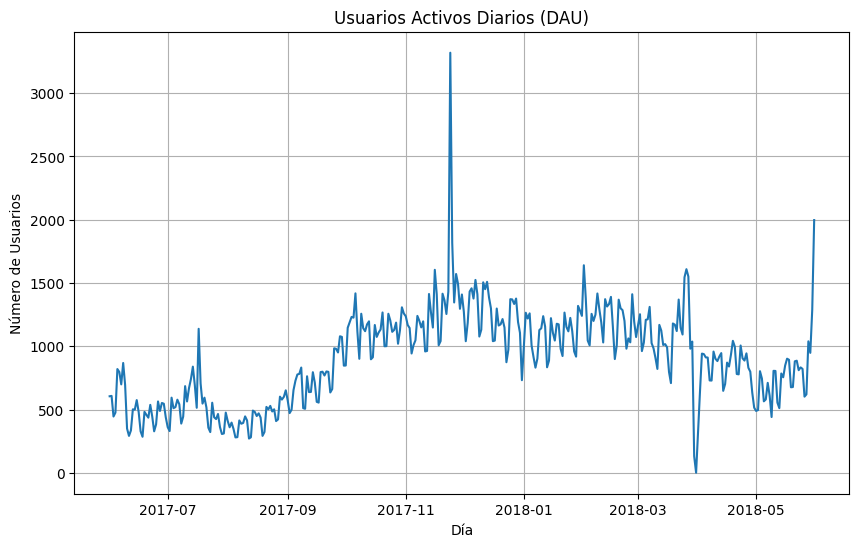

In [80]:
# Create a line plot for DAU
plt.figure(figsize=(10, 6))
plt.plot(dau.index, dau['uid'])
plt.title('Usuarios Activos Diarios (DAU)')
plt.xlabel('Día')
plt.ylabel('Número de Usuarios')
plt.grid(True)
plt.show()

Viendo ésta tabla pensaríamos que a finales de noviembre fué muy bien, veamos el semanal:

In [25]:
wau = visits.groupby('sesion_semana').agg({'uid': 'nunique'})
print(wau.mean(), 'visitantes semanales promedio')

uid    5825.288462
dtype: float64 visitantes semanales promedio


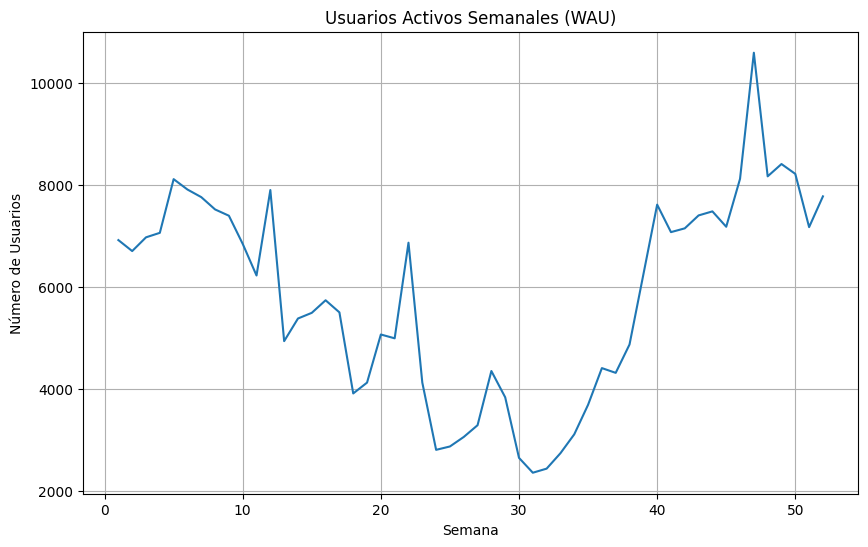

In [26]:
# Create a line plot for WAU
plt.figure(figsize=(10, 6))
plt.plot(wau.index, wau['uid'])
plt.title('Usuarios Activos Semanales (WAU)')
plt.xlabel('Semana')
plt.ylabel('Número de Usuarios')
plt.grid(True)
plt.show()

Aquí parece lo contrario, muy bajo en noviembre menos por un pequeño repunte.

In [27]:
mau = visits.groupby('sesion_mes').agg({'uid': 'nunique'})
print(mau.mean(), 'visitantes mensuales promedio')

uid    23228.416667
dtype: float64 visitantes mensuales promedio


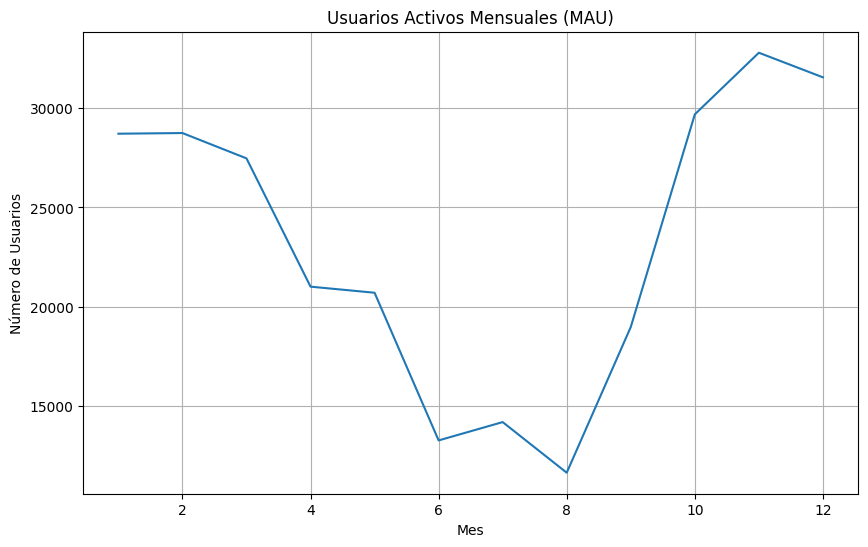

In [28]:
# Create a line plot for MAU
plt.figure(figsize=(10, 6))
plt.plot(mau.index, mau['uid'])
plt.title('Usuarios Activos Mensuales (MAU)')
plt.xlabel('Mes')
plt.ylabel('Número de Usuarios')
plt.grid(True)
plt.show()

En general la mitad del año de septiembre a febrero baja mucho, a excepcion de un repunte de un día a final de año y podemos ver que aquí noviembre con todo y que obtuvo uno de los días más ocupados fué de cualquier modo uno de los meses más bajos.

### Sesiones por día

In [29]:
sesion_usuario = visits.groupby('sesion_fecha').agg({'uid': ['count','nunique']})
sesion_usuario.columns = ['n_sesiones', 'n_usuarios']
sesion_usuario['sesion_x_usuario'] = sesion_usuario['n_sesiones'] / sesion_usuario['n_usuarios']
sesion_usuario.head()

,n_sesiones,n_usuarios,sesion_x_usuario
sesion_fecha,,,
2017-06-01,664,605,1.097521
2017-06-02,658,608,1.082237
2017-06-03,477,445,1.071910
2017-06-04,510,476,1.071429
2017-06-05,893,820,1.089024


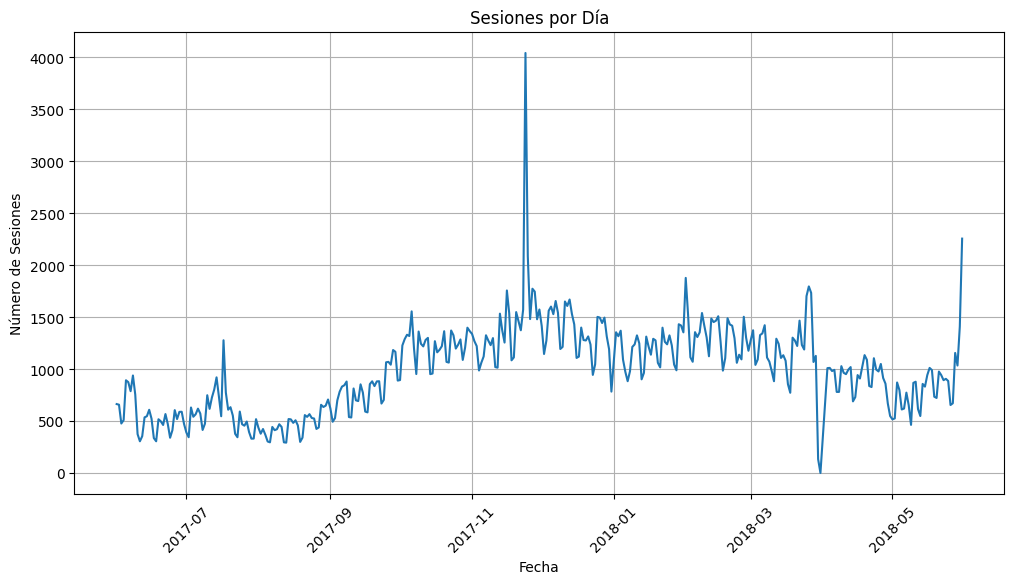

In [30]:
# Gráfica de sesiones por día
plt.figure(figsize=(12, 6))
plt.plot(sesion_usuario.index, sesion_usuario['n_sesiones'])
plt.title('Sesiones por Día')
plt.xlabel('Fecha')
plt.ylabel('Número de Sesiones')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

conclusiones

### Tiempo que dura cada sesión.

In [31]:
visits['duracion_sesion_seg'] = (visits['final_sesion_ts'] - visits['inicio_sesion_ts']).dt.seconds
visits['duracion_sesion_seg'].describe()

,duracion_sesion_seg
count,359400.000000
mean,643.506489
std,1016.334786
min,0.000000
25%,120.000000
50%,300.000000
75%,840.000000
max,84480.000000


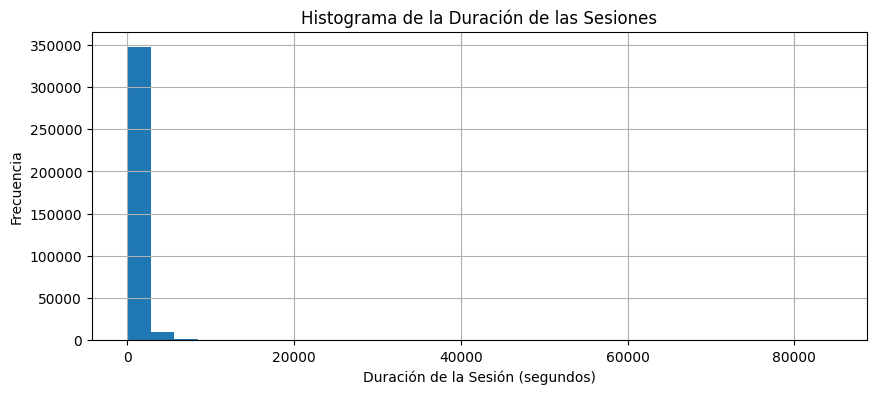

In [32]:
# Histograma de la duración de las sesiones
plt.figure(figsize=(10, 4))
plt.hist(visits['duracion_sesion_seg'], bins=30)
plt.title('Histograma de la Duración de las Sesiones')
plt.xlabel('Duración de la Sesión (segundos)')
plt.ylabel('Frecuencia')
plt.grid(True)
plt.show()

## conclusiones

### Tasa de Retención de Usuarios.

In [33]:
primer_visita = visits.groupby('uid').agg({'inicio_sesion_ts': 'min'}).reset_index()
primer_visita.columns = ['uid', 'primer_inicio_sesion_ts']
primer_visita.head()

,uid,primer_inicio_sesion_ts
0,11863502262781,2018-03-01 17:27:00
1,49537067089222,2018-02-06 15:55:00
2,297729379853735,2017-06-07 18:47:00
3,313578113262317,2017-09-18 22:49:00
4,325320750514679,2017-09-30 14:29:00


In [34]:
primer_visita['primer_sesion_dt'] = primer_visita['primer_inicio_sesion_ts'].dt.date
primer_visita['primer_sesion_mes']  = primer_visita['primer_inicio_sesion_ts'].dt.month

visitas_completo = pd.merge(primer_visita, visits, on = 'uid')
visitas_completo

,uid,primer_inicio_sesion_ts,primer_sesion_dt,primer_sesion_mes,device,final_sesion_ts,source_id,inicio_sesion_ts,sesion_mes,sesion_semana,sesion_fecha,duracion_sesion_seg
0,11863502262781,2018-03-01 17:27:00,2018-03-01,3,touch,2018-03-01 17:33:00,3,2018-03-01 17:27:00,3,9,2018-03-01,360
1,49537067089222,2018-02-06 15:55:00,2018-02-06,2,touch,2018-02-06 15:57:00,2,2018-02-06 15:55:00,2,6,2018-02-06,120
2,297729379853735,2017-06-07 18:47:00,2017-06-07,6,desktop,2017-06-07 18:48:00,3,2017-06-07 18:47:00,6,23,2017-06-07,60
3,313578113262317,2017-09-18 22:49:00,2017-09-18,9,desktop,2018-03-11 17:29:00,2,2018-03-11 17:23:00,3,10,2018-03-11,360
4,313578113262317,2017-09-18 22:49:00,2017-09-18,9,desktop,2017-09-18 23:07:00,2,2017-09-18 22:49:00,9,38,2017-09-18,1080
...,...,...,...,...,...,...,...,...,...,...,...,...
359395,18446424184725333426,2017-12-06 20:32:00,2017-12-06,12,touch,2017-12-06 20:32:00,4,2017-12-06 20:32:00,12,49,2017-12-06,0
359396,18446556406699109058,2018-01-01 16:29:00,2018-01-01,1,touch,2018-01-01 16:31:00,3,2018-01-01 16:29:00,1,1,2018-01-01,120
359397,18446621818809592527,2017-12-27 13:27:00,2017-12-27,12,desktop,2018-05-21 09:45:00,4,2018-05-21 09:30:00,5,21,2018-05-21,900
359398,18446621818809592527,2017-12-27 13:27:00,2017-12-27,12,desktop,2017-12-27 14:08:00,4,2017-12-27 13:27:00,12,52,2017-12-27,2460


In [35]:
visitas_completo['edad_meses'] = ((visitas_completo['sesion_mes']- visitas_completo['primer_sesion_mes'])/np.timedelta64(1,'M').astype('int'))
visitas_completo.head()

,uid,primer_inicio_sesion_ts,primer_sesion_dt,primer_sesion_mes,device,final_sesion_ts,source_id,inicio_sesion_ts,sesion_mes,sesion_semana,sesion_fecha,duracion_sesion_seg,edad_meses
0,11863502262781,2018-03-01 17:27:00,2018-03-01,3,touch,2018-03-01 17:33:00,3,2018-03-01 17:27:00,3,9,2018-03-01,360,0.0
1,49537067089222,2018-02-06 15:55:00,2018-02-06,2,touch,2018-02-06 15:57:00,2,2018-02-06 15:55:00,2,6,2018-02-06,120,0.0
2,297729379853735,2017-06-07 18:47:00,2017-06-07,6,desktop,2017-06-07 18:48:00,3,2017-06-07 18:47:00,6,23,2017-06-07,60,0.0
3,313578113262317,2017-09-18 22:49:00,2017-09-18,9,desktop,2018-03-11 17:29:00,2,2018-03-11 17:23:00,3,10,2018-03-11,360,-6.0
4,313578113262317,2017-09-18 22:49:00,2017-09-18,9,desktop,2017-09-18 23:07:00,2,2017-09-18 22:49:00,9,38,2017-09-18,1080,0.0


Tabla dinámica para cohortes (heatmap)

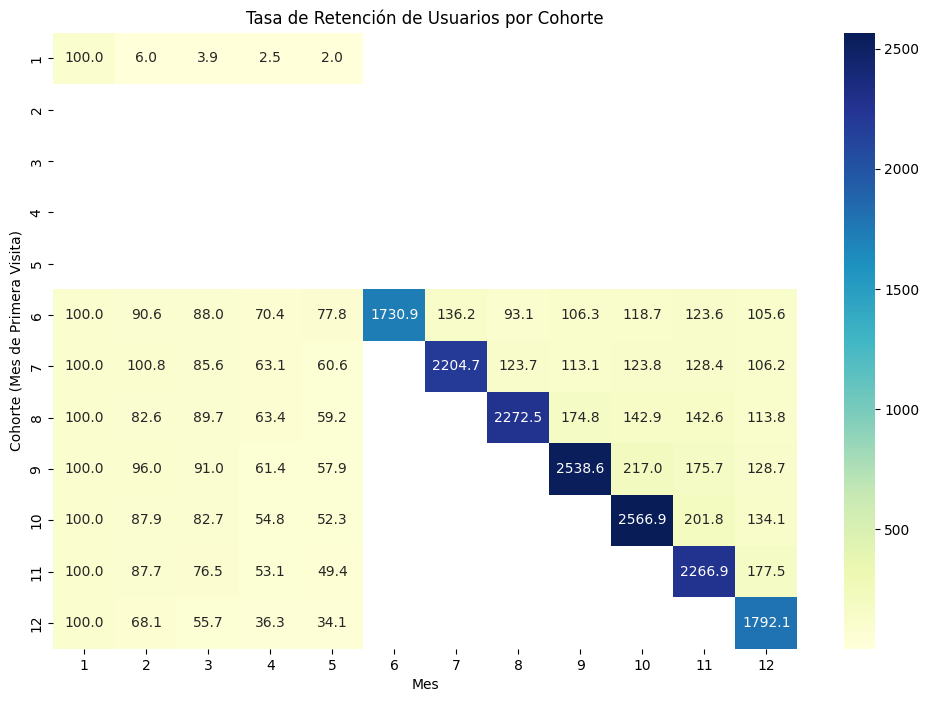

In [82]:
# Crear la tabla dinámica para cohortes
cohort_table = visitas_completo.groupby(['primer_sesion_mes', 'sesion_mes'])['uid'].nunique().unstack()

# Calcular la tasa de retención
cohort_size = cohort_table.iloc[:, 0]
retention_matrix = cohort_table.divide(cohort_size, axis=0) * 100

# Crear el heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(retention_matrix, annot=True, fmt=".1f", cmap="YlGnBu")
plt.title("Tasa de Retención de Usuarios por Cohorte")
plt.xlabel("Mes")
plt.ylabel("Cohorte (Mes de Primera Visita)")
plt.show()

In [37]:
cohortes = visitas_completo.pivot_table( index='primer_sesion_mes', columns='edad_meses', values='uid', aggfunc='nunique')
cohortes.fillna('')

edad_meses,-11.0,-10.0,-9.0,-8.0,-7.0,-6.0,-5.0,-4.0,-3.0,-2.0,-1.0,0.0,1.0,2.0,3.0,4.0,5.0,6.0
primer_sesion_mes,,,,,,,,,,,,,,,,,,
1,,,,,,,,,,,,22624.0,1351.0,890.0,565.0,458.0,,
2,,,,,,,,,,,,22197.0,1267.0,565.0,446.0,,,
3,,,,,,,,,,,,20589.0,861.0,557.0,,,,
4,,,,,,,,,,,,15709.0,760.0,,,,,
5,,,,,,,,,,,,15273.0,,,,,,
6,,,,,,,766.0,694.0,674.0,539.0,596.0,13259.0,1043.0,713.0,814.0,909.0,947.0,809.0
7,,,,,,596.0,601.0,510.0,376.0,361.0,,13140.0,737.0,674.0,738.0,765.0,633.0,
8,,,,,448.0,370.0,402.0,284.0,265.0,,,10181.0,783.0,640.0,639.0,510.0,,
9,,,,658.0,632.0,599.0,404.0,381.0,,,,16704.0,1428.0,1156.0,847.0,,,


# Ventas

## Duración de compra desde la primera visita (KPI)

In [38]:
orders.head()

,tiempo_de_compra,ingreso,uid
0,2017-06-01 00:10:00,17.00,10329302124590727494
1,2017-06-01 00:25:00,0.55,11627257723692907447
2,2017-06-01 00:27:00,0.37,17903680561304213844
3,2017-06-01 00:29:00,0.55,16109239769442553005
4,2017-06-01 07:58:00,0.37,14200605875248379450


In [39]:
orders['orden_dt'] = orders['tiempo_de_compra'].dt.date
orders['orden_mes'] = orders['tiempo_de_compra'].dt.to_period('M')
orders

,tiempo_de_compra,ingreso,uid,orden_dt,orden_mes
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01,2017-06
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01,2017-06
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01,2017-06
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01,2017-06
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01,2017-06
...,...,...,...,...,...
50410,2018-05-31 23:50:00,4.64,12296626599487328624,2018-05-31,2018-05
50411,2018-05-31 23:50:00,5.80,11369640365507475976,2018-05-31,2018-05
50412,2018-05-31 23:54:00,0.30,1786462140797698849,2018-05-31,2018-05
50413,2018-05-31 23:56:00,3.67,3993697860786194247,2018-05-31,2018-05


In [40]:
primer_orden = orders.groupby('uid').agg({'tiempo_de_compra': 'min'}).reset_index()
primer_orden.columns = ['uid', 'primer_orden_ts']
primer_orden['primer_orden_dt'] = primer_orden['primer_orden_ts'].dt.date
primer_orden['primer_orden_mes'] = primer_orden['primer_orden_ts'].dt.to_period('M')

primer_orden.head()

,uid,primer_orden_ts,primer_orden_dt,primer_orden_mes
0,313578113262317,2018-01-03 21:51:00,2018-01-03,2018-01
1,1575281904278712,2017-06-03 10:13:00,2017-06-03,2017-06
2,2429014661409475,2017-10-11 18:33:00,2017-10-11,2017-10
3,2464366381792757,2018-01-28 15:54:00,2018-01-28,2018-01
4,2551852515556206,2017-11-24 10:14:00,2017-11-24,2017-11


In [41]:
compradores = pd.merge(primer_visita, primer_orden, on='uid')

compradores.head()

,uid,primer_inicio_sesion_ts,primer_sesion_dt,primer_sesion_mes,primer_orden_ts,primer_orden_dt,primer_orden_mes
0,313578113262317,2017-09-18 22:49:00,2017-09-18,9,2018-01-03 21:51:00,2018-01-03,2018-01
1,1575281904278712,2017-06-03 10:13:00,2017-06-03,6,2017-06-03 10:13:00,2017-06-03,2017-06
2,2429014661409475,2017-10-11 17:14:00,2017-10-11,10,2017-10-11 18:33:00,2017-10-11,2017-10
3,2464366381792757,2018-01-27 20:10:00,2018-01-27,1,2018-01-28 15:54:00,2018-01-28,2018-01
4,2551852515556206,2017-11-24 10:14:00,2017-11-24,11,2017-11-24 10:14:00,2017-11-24,2017-11


In [42]:
compradores.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36523 entries, 0 to 36522
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   uid                      36523 non-null  uint64        
 1   primer_inicio_sesion_ts  36523 non-null  datetime64[ns]
 2   primer_sesion_dt         36523 non-null  object        
 3   primer_sesion_mes        36523 non-null  int32         
 4   primer_orden_ts          36523 non-null  datetime64[ns]
 5   primer_orden_dt          36523 non-null  object        
 6   primer_orden_mes         36523 non-null  period[M]     
dtypes: datetime64[ns](2), int32(1), object(2), period[M](1), uint64(1)
memory usage: 1.8+ MB


In [43]:
compradores['primer_sesion_dt'] = pd.to_datetime(compradores['primer_sesion_dt'])
compradores['primer_orden_dt'] = pd.to_datetime(compradores['primer_orden_dt'])

In [44]:
compradores['dias_hasta_compra'] = ((compradores['primer_orden_ts'] - compradores['primer_inicio_sesion_ts'])/np.timedelta64(1,'D')).astype('int')
compradores.head()

,uid,primer_inicio_sesion_ts,primer_sesion_dt,primer_sesion_mes,primer_orden_ts,primer_orden_dt,primer_orden_mes,dias_hasta_compra
0,313578113262317,2017-09-18 22:49:00,2017-09-18,9,2018-01-03 21:51:00,2018-01-03,2018-01,106
1,1575281904278712,2017-06-03 10:13:00,2017-06-03,6,2017-06-03 10:13:00,2017-06-03,2017-06,0
2,2429014661409475,2017-10-11 17:14:00,2017-10-11,10,2017-10-11 18:33:00,2017-10-11,2017-10,0
3,2464366381792757,2018-01-27 20:10:00,2018-01-27,1,2018-01-28 15:54:00,2018-01-28,2018-01,0
4,2551852515556206,2017-11-24 10:14:00,2017-11-24,11,2017-11-24 10:14:00,2017-11-24,2017-11,0


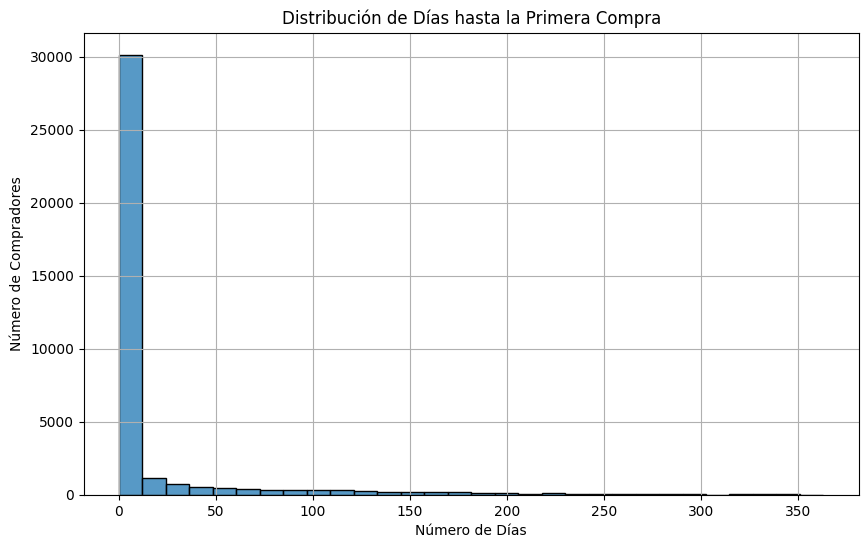

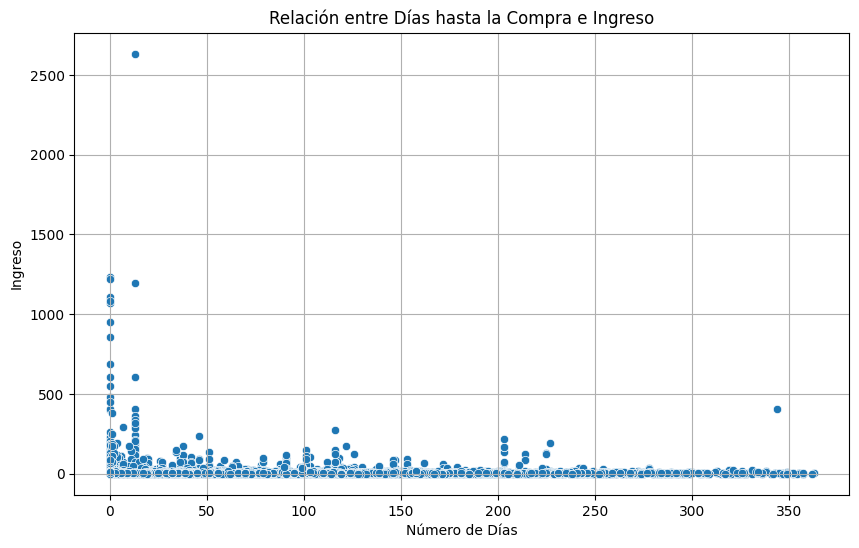

In [45]:
# Crear un histograma de la distribución de días hasta la compra
plt.figure(figsize=(10, 6))
sns.histplot(compradores['dias_hasta_compra'], bins=30)
plt.title('Distribución de Días hasta la Primera Compra')
plt.xlabel('Número de Días')
plt.ylabel('Número de Compradores')
plt.grid(True)
plt.show()

# Crear una gráfica de dispersión para visualizar la relación entre el número de días hasta la compra y el ingreso
plt.figure(figsize=(10, 6))
sns.scatterplot(x='dias_hasta_compra', y='ingreso', data=pd.merge(compradores, orders, on='uid'))
plt.title('Relación entre Días hasta la Compra e Ingreso')
plt.xlabel('Número de Días')
plt.ylabel('Ingreso')
plt.grid(True)
plt.show()

La mayoria de nuestros clientes compran en las primeras visitas

### Número de pedidos de compra por cliente

In [46]:
tamano_cohortes = compradores.groupby('primer_orden_mes').agg({'uid':'nunique'}).reset_index()
tamano_cohortes.rename(columns={'uid': 'n_compradores'}, inplace = True)
tamano_cohortes.head(10)

,primer_orden_mes,n_compradores
0,2017-06,2023
1,2017-07,1923
2,2017-08,1370
3,2017-09,2581
4,2017-10,4340
5,2017-11,4081
6,2017-12,4383
7,2018-01,3373
8,2018-02,3651
9,2018-03,3533


In [47]:
grupos = pd.merge(orders, compradores, on='uid')
grupos = grupos.groupby(['primer_orden_mes', 'orden_mes']).agg({'ingreso':'count'}).reset_index()

grupos.head()

,primer_orden_mes,orden_mes,ingreso
0,2017-06,2017-06,2354
1,2017-06,2017-07,177
2,2017-06,2017-08,174
3,2017-06,2017-09,226
4,2017-06,2017-10,292


In [48]:
grupos['edad_meses'] = (grupos['orden_mes']-grupos['primer_orden_mes']).apply(lambda x: x.n)

grupos.columns = ['primer_orden_mes', 'orden_mes', 'n_ordenes', 'edad_meses']

grupos.head()

,primer_orden_mes,orden_mes,n_ordenes,edad_meses
0,2017-06,2017-06,2354,0
1,2017-06,2017-07,177,1
2,2017-06,2017-08,174,2
3,2017-06,2017-09,226,3
4,2017-06,2017-10,292,4


In [49]:
grupos_reporte = pd.merge(tamano_cohortes, grupos, on='primer_orden_mes')
grupos_reporte.head()

,primer_orden_mes,n_compradores,orden_mes,n_ordenes,edad_meses
0,2017-06,2023,2017-06,2354,0
1,2017-06,2023,2017-07,177,1
2,2017-06,2023,2017-08,174,2
3,2017-06,2023,2017-09,226,3
4,2017-06,2023,2017-10,292,4


Sin lugar a dudas el primer mes es el mas importante para nuestros clientes

In [50]:
grupos_reporte['orden_por_comprador'] = (grupos_reporte['n_ordenes']/grupos_reporte['n_compradores'])
grupos_reporte.head()

,primer_orden_mes,n_compradores,orden_mes,n_ordenes,edad_meses,orden_por_comprador
0,2017-06,2023,2017-06,2354,0,1.163618
1,2017-06,2023,2017-07,177,1,0.087494
2,2017-06,2023,2017-08,174,2,0.086011
3,2017-06,2023,2017-09,226,3,0.111715
4,2017-06,2023,2017-10,292,4,0.144340


In [51]:
grupos_reporte_LTV = grupos_reporte.pivot_table( index='primer_orden_mes', columns='edad_meses', values='orden_por_comprador', aggfunc='sum').cumsum(axis = 1)
grupos_reporte_LTV.round(2).fillna('')

edad_meses,0,1,2,3,4,5,6,7,8,9,10,11
primer_orden_mes,,,,,,,,,,,,
2017-06,1.16,1.25,1.34,1.45,1.59,1.7,1.84,1.92,2.03,2.1,2.15,2.19
2017-07,1.14,1.19,1.25,1.31,1.34,1.39,1.42,1.44,1.47,1.49,1.51,
2017-08,1.12,1.2,1.27,1.33,1.39,1.44,1.47,1.53,1.56,1.6,,
2017-09,1.14,1.22,1.28,1.35,1.37,1.42,1.46,1.48,1.5,,,
2017-10,1.14,1.22,1.25,1.28,1.31,1.34,1.35,1.38,,,,
2017-11,1.18,1.28,1.32,1.37,1.41,1.42,1.45,,,,,
2017-12,1.15,1.21,1.26,1.3,1.32,1.34,,,,,,
2018-01,1.12,1.19,1.24,1.25,1.28,,,,,,,
2018-02,1.12,1.18,1.21,1.22,,,,,,,,


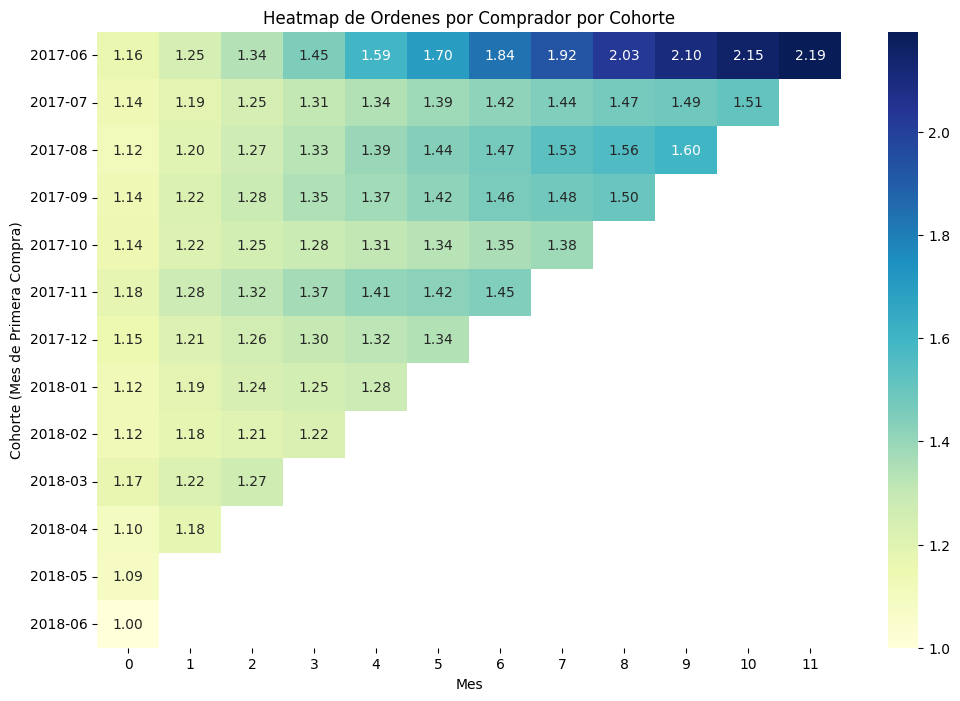

In [52]:
plt.figure(figsize=(12, 8))
sns.heatmap(grupos_reporte.pivot_table(index='primer_orden_mes', columns='edad_meses', values='orden_por_comprador', aggfunc='sum').cumsum(axis = 1), annot=True, fmt=".2f", cmap="YlGnBu")
plt.title("Heatmap de Ordenes por Comprador por Cohorte")
plt.xlabel("Mes")
plt.ylabel("Cohorte (Mes de Primera Compra)")
plt.show()

Podemos ver un heatmap de los cohortes

In [53]:
orders['ingreso'].mean()

4.999646930477041

Ingreso promedio por orden.

# Marketing

## ¿Cuánto dinero se gastó? Total por fuente de adquisición a lo largo del tiempo

In [54]:
total_gasto = costs.groupby('source_id').agg({'costs':'sum'})
total_gasto.round(2)

,costs
source_id,
1,20833.27
2,42806.04
3,141321.63
4,61073.60
5,51757.10
9,5517.49
10,5822.49


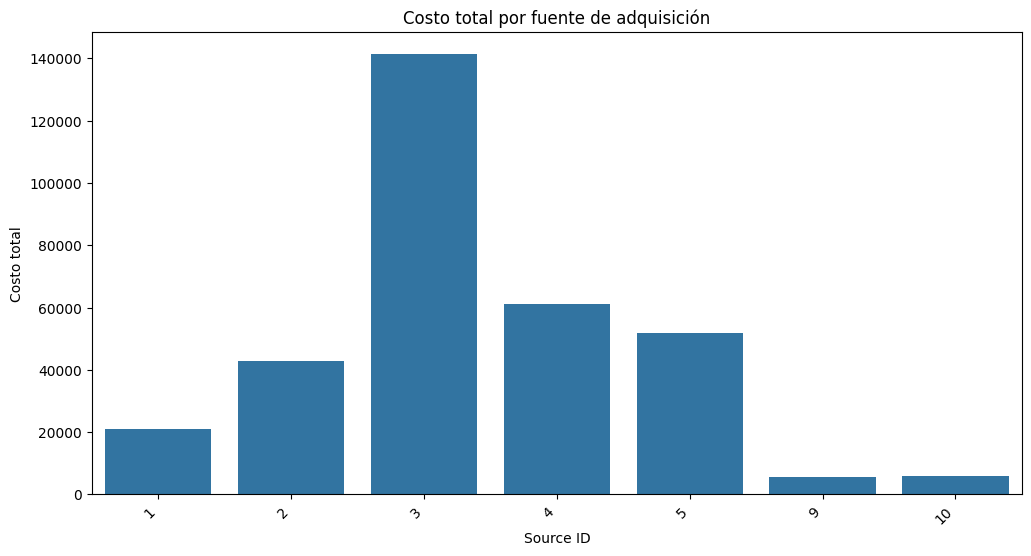

In [55]:
plt.figure(figsize=(12, 6))
sns.barplot(x=total_gasto.index, y=total_gasto['costs'])
plt.title('Costo total por fuente de adquisición')
plt.xlabel('Source ID')
plt.ylabel('Costo total')
plt.xticks(rotation=45, ha='right')
plt.show()

La tercer fuente fué mucho más costosa que las demás. Por más del doble que cualquier otra.

In [56]:
costs['costs'].sum()

329131.62

costo total de = 329131.62

In [57]:
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   source_id  2542 non-null   int64         
 1   dt         2542 non-null   datetime64[ns]
 2   costs      2542 non-null   float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 59.7 KB


In [58]:
costs['dt_month'] = costs['dt'].dt.to_period('M')
costs.head()

,source_id,dt,costs,dt_month
0,1,2017-06-01,75.20,2017-06
1,1,2017-06-02,62.25,2017-06
2,1,2017-06-03,36.53,2017-06
3,1,2017-06-04,55.00,2017-06
4,1,2017-06-05,57.08,2017-06


In [59]:
costo_mes = costs.pivot_table(index='dt_month', values='costs', aggfunc='sum')
costo_mes

,costs
dt_month,
2017-06,18015.00
2017-07,18240.59
2017-08,14790.54
2017-09,24368.91
2017-10,36322.88
2017-11,37907.88
2017-12,38315.35
2018-01,33518.52
2018-02,32723.03


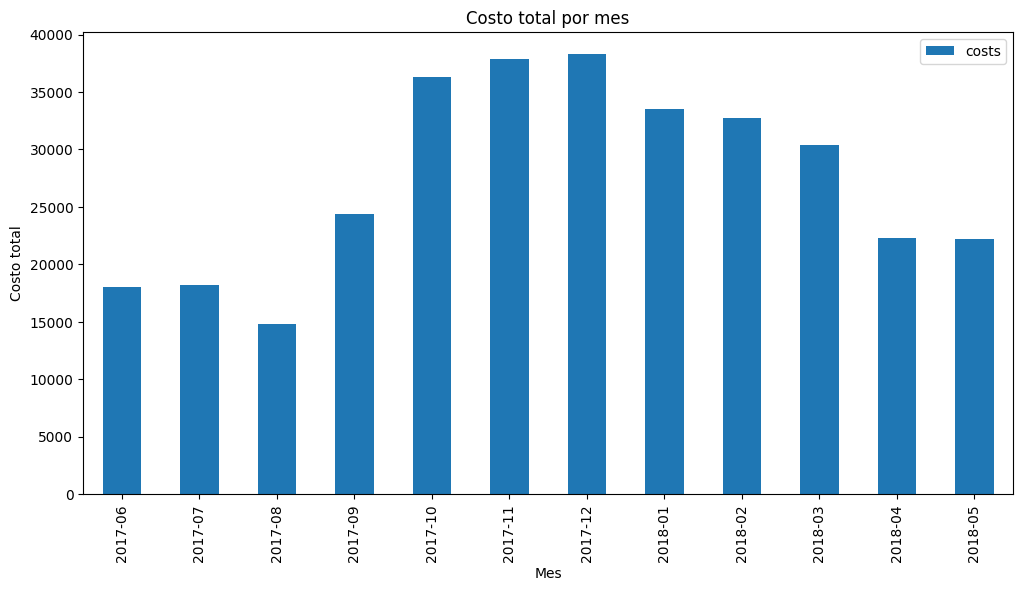

In [60]:
costo_mes.plot(kind='bar', figsize=(12, 6))
plt.title('Costo total por mes')
plt.xlabel('Mes')
plt.ylabel('Costo total')
plt.show()

Los meses de Octubre, Noviembre y Diciembre que fueron los más bajos en usuarios activos también fueron los más costosos.

¿Cuál fue el costo de adquisición de clientes de cada una de las fuentes?

In [61]:
costo_fuente = costs.groupby('source_id').agg({'costs':'sum'})
costo_fuente.round(2)

,costs
source_id,
1,20833.27
2,42806.04
3,141321.63
4,61073.60
5,51757.10
9,5517.49
10,5822.49


Parece un Dejavú de información.

In [62]:
cac_fuente = costs['costs'].sum() / orders['uid'].nunique()
print('costo de adquisición por cliente', cac_fuente.round(2))

costo de adquisición por cliente 9.01


In [63]:
costos_cac = costs.groupby('dt_month').agg({'costs':'sum'})
costos_cac

,costs
dt_month,
2017-06,18015.00
2017-07,18240.59
2017-08,14790.54
2017-09,24368.91
2017-10,36322.88
2017-11,37907.88
2017-12,38315.35
2018-01,33518.52
2018-02,32723.03


In [64]:
compradores_mes = compradores.groupby('primer_orden_mes').agg({'uid':'nunique'})
compradores_mes


,uid
primer_orden_mes,
2017-06,2023
2017-07,1923
2017-08,1370
2017-09,2581
2017-10,4340
2017-11,4081
2017-12,4383
2018-01,3373
2018-02,3651


El último mes consta de una persona que inició sesión antes de media noche del 31 de Mayo y la terminó el primero de Junio de 2018.

In [65]:
cac_por_mes = pd.merge(costos_cac, compradores_mes, left_index=True, right_index=True)
cac_por_mes['cac'] = cac_por_mes['costs'] / cac_por_mes['uid']
cac_por_mes.round(2)

,costs,uid,cac
2017-06,18015.00,2023,8.91
2017-07,18240.59,1923,9.49
2017-08,14790.54,1370,10.80
2017-09,24368.91,2581,9.44
2017-10,36322.88,4340,8.37
2017-11,37907.88,4081,9.29
2017-12,38315.35,4383,8.74
2018-01,33518.52,3373,9.94
2018-02,32723.03,3651,8.96
2018-03,30415.27,3533,8.61


Text(0, 0.5, 'Costo de Adquisición por Cliente')

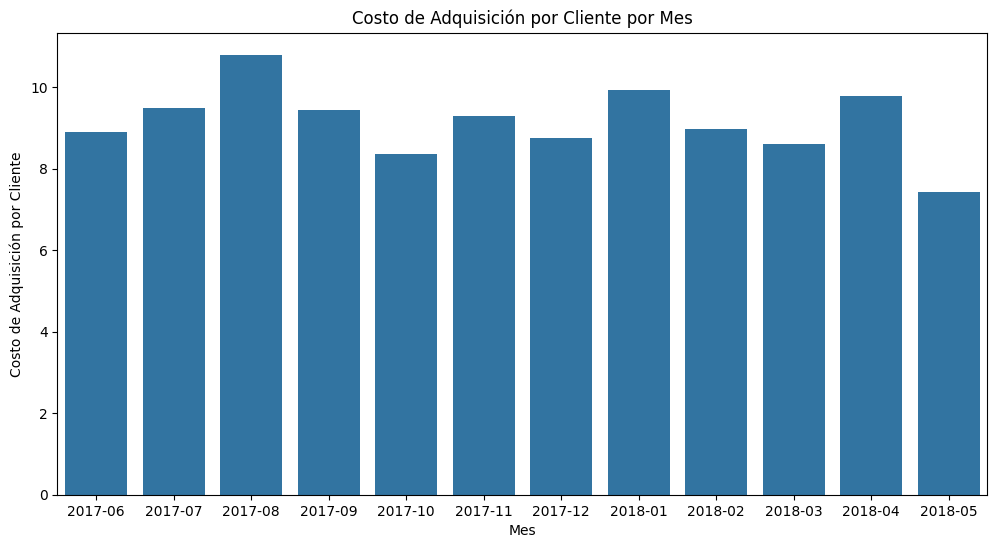

In [85]:
plt.figure(figsize=(12, 6))
sns.barplot(x=cac_por_mes.index, y=cac_por_mes['cac'])
plt.title('Costo de Adquisición por Cliente por Mes')
plt.xlabel('Mes')
plt.ylabel('Costo de Adquisición por Cliente')

parece ser un poco constante entre 7 y 10.

In [66]:
visitas_completo.head()

,uid,primer_inicio_sesion_ts,primer_sesion_dt,primer_sesion_mes,device,final_sesion_ts,source_id,inicio_sesion_ts,sesion_mes,sesion_semana,sesion_fecha,duracion_sesion_seg,edad_meses
0,11863502262781,2018-03-01 17:27:00,2018-03-01,3,touch,2018-03-01 17:33:00,3,2018-03-01 17:27:00,3,9,2018-03-01,360,0.0
1,49537067089222,2018-02-06 15:55:00,2018-02-06,2,touch,2018-02-06 15:57:00,2,2018-02-06 15:55:00,2,6,2018-02-06,120,0.0
2,297729379853735,2017-06-07 18:47:00,2017-06-07,6,desktop,2017-06-07 18:48:00,3,2017-06-07 18:47:00,6,23,2017-06-07,60,0.0
3,313578113262317,2017-09-18 22:49:00,2017-09-18,9,desktop,2018-03-11 17:29:00,2,2018-03-11 17:23:00,3,10,2018-03-11,360,-6.0
4,313578113262317,2017-09-18 22:49:00,2017-09-18,9,desktop,2017-09-18 23:07:00,2,2017-09-18 22:49:00,9,38,2017-09-18,1080,0.0


In [67]:
usuarios = visitas_completo.sort_values('inicio_sesion_ts').groupby('uid').first()
usuarios = usuarios[['source_id']]

In [68]:
compradores = pd.merge(compradores, usuarios, left_on='uid', right_index= True)
compradores.head()

,uid,primer_inicio_sesion_ts,primer_sesion_dt,primer_sesion_mes,primer_orden_ts,primer_orden_dt,primer_orden_mes,dias_hasta_compra,source_id
0,313578113262317,2017-09-18 22:49:00,2017-09-18,9,2018-01-03 21:51:00,2018-01-03,2018-01,106,2
1,1575281904278712,2017-06-03 10:13:00,2017-06-03,6,2017-06-03 10:13:00,2017-06-03,2017-06,0,10
2,2429014661409475,2017-10-11 17:14:00,2017-10-11,10,2017-10-11 18:33:00,2017-10-11,2017-10,0,3
3,2464366381792757,2018-01-27 20:10:00,2018-01-27,1,2018-01-28 15:54:00,2018-01-28,2018-01,0,5
4,2551852515556206,2017-11-24 10:14:00,2017-11-24,11,2017-11-24 10:14:00,2017-11-24,2017-11,0,5


In [69]:
compradores_diario = compradores.groupby(['source_id', 'primer_orden_dt']).agg({'uid':'count'}).reset_index()
compradores_diario.rename(columns={'uid': 'n_compradores'}, inplace = True)
compradores_diario['primer_orden_dt'] = pd.to_datetime(compradores_diario['primer_orden_dt'])
compradores_diario.head()

,source_id,primer_orden_dt,n_compradores
0,1,2017-06-01,14
1,1,2017-06-02,7
2,1,2017-06-03,7
3,1,2017-06-04,3
4,1,2017-06-05,18


In [70]:
costos_2 = pd.merge(compradores_diario, costs, left_on=['source_id', 'primer_orden_dt'], right_on=['source_id', 'dt'])
costos_2.head()

,source_id,primer_orden_dt,n_compradores,dt,costs,dt_month
0,1,2017-06-01,14,2017-06-01,75.20,2017-06
1,1,2017-06-02,7,2017-06-02,62.25,2017-06
2,1,2017-06-03,7,2017-06-03,36.53,2017-06
3,1,2017-06-04,3,2017-06-04,55.00,2017-06
4,1,2017-06-05,18,2017-06-05,57.08,2017-06


In [71]:
costos_2['cac'] = costos_2['costs'] / costos_2['n_compradores']
costos_2.head()

,source_id,primer_orden_dt,n_compradores,dt,costs,dt_month,cac
0,1,2017-06-01,14,2017-06-01,75.20,2017-06,5.371429
1,1,2017-06-02,7,2017-06-02,62.25,2017-06,8.892857
2,1,2017-06-03,7,2017-06-03,36.53,2017-06,5.218571
3,1,2017-06-04,3,2017-06-04,55.00,2017-06,18.333333
4,1,2017-06-05,18,2017-06-05,57.08,2017-06,3.171111


In [72]:
cac_month = costos_2.pivot_table(index='dt_month', columns='source_id', values='cac', aggfunc='mean').head()

In [73]:
costos_2.groupby('source_id').agg({'cac':'mean'}).round(2)

,cac
source_id,
1,9.49
2,16.29
3,15.58
4,7.27
5,8.34
9,6.84
10,6.56


## ROMI

In [74]:
orders

,tiempo_de_compra,ingreso,uid,orden_dt,orden_mes
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01,2017-06
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01,2017-06
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01,2017-06
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01,2017-06
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01,2017-06
...,...,...,...,...,...
50410,2018-05-31 23:50:00,4.64,12296626599487328624,2018-05-31,2018-05
50411,2018-05-31 23:50:00,5.80,11369640365507475976,2018-05-31,2018-05
50412,2018-05-31 23:54:00,0.30,1786462140797698849,2018-05-31,2018-05
50413,2018-05-31 23:56:00,3.67,3993697860786194247,2018-05-31,2018-05


In [75]:
ingreso_mes = orders.groupby(['uid', 'orden_mes']).agg({'ingreso':'sum'}).reset_index()
ingreso_mes.head()

,uid,orden_mes,ingreso
0,313578113262317,2018-01,0.55
1,1575281904278712,2017-06,3.05
2,2429014661409475,2017-10,73.33
3,2464366381792757,2018-01,2.44
4,2551852515556206,2017-11,10.99


In [76]:
compradores = pd.merge (compradores, ingreso_mes, on='uid')
compradores.head()

,uid,primer_inicio_sesion_ts,primer_sesion_dt,primer_sesion_mes,primer_orden_ts,primer_orden_dt,primer_orden_mes,dias_hasta_compra,source_id,orden_mes,ingreso
0,313578113262317,2017-09-18 22:49:00,2017-09-18,9,2018-01-03 21:51:00,2018-01-03,2018-01,106,2,2018-01,0.55
1,1575281904278712,2017-06-03 10:13:00,2017-06-03,6,2017-06-03 10:13:00,2017-06-03,2017-06,0,10,2017-06,3.05
2,2429014661409475,2017-10-11 17:14:00,2017-10-11,10,2017-10-11 18:33:00,2017-10-11,2017-10,0,3,2017-10,73.33
3,2464366381792757,2018-01-27 20:10:00,2018-01-27,1,2018-01-28 15:54:00,2018-01-28,2018-01,0,5,2018-01,2.44
4,2551852515556206,2017-11-24 10:14:00,2017-11-24,11,2017-11-24 10:14:00,2017-11-24,2017-11,0,5,2017-11,10.99


In [77]:
costs

,source_id,dt,costs,dt_month
0,1,2017-06-01,75.20,2017-06
1,1,2017-06-02,62.25,2017-06
2,1,2017-06-03,36.53,2017-06
3,1,2017-06-04,55.00,2017-06
4,1,2017-06-05,57.08,2017-06
...,...,...,...,...
2537,10,2018-05-27,9.92,2018-05
2538,10,2018-05-28,21.26,2018-05
2539,10,2018-05-29,11.32,2018-05
2540,10,2018-05-30,33.15,2018-05


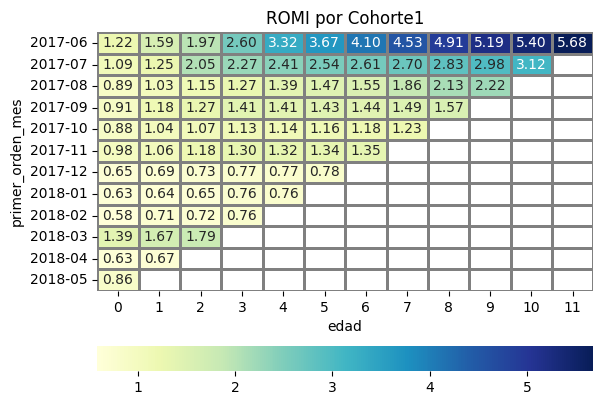

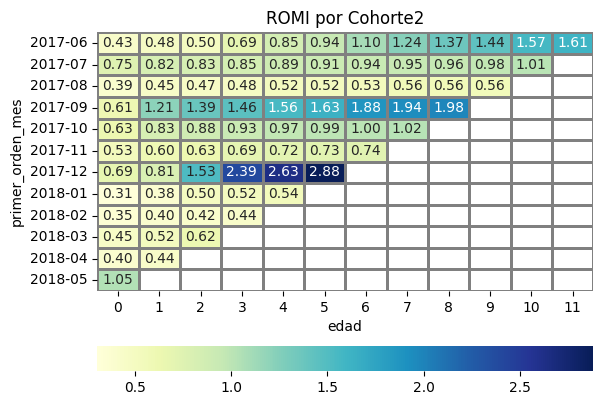

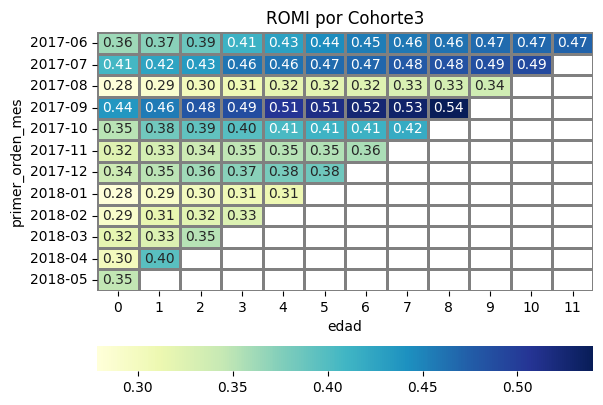

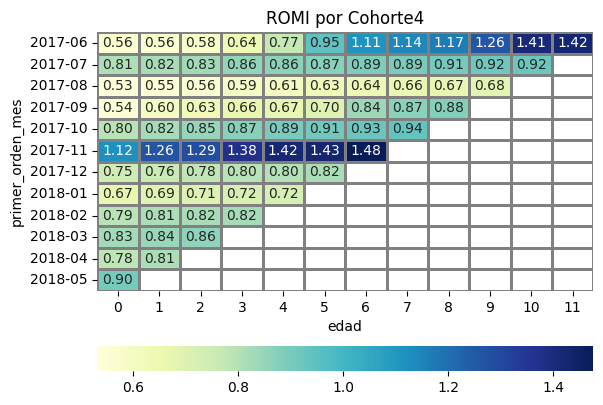

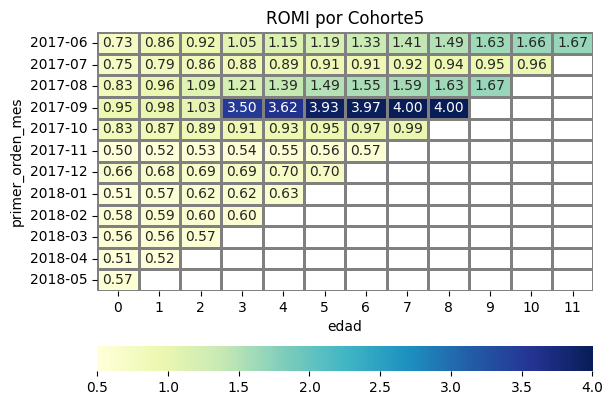

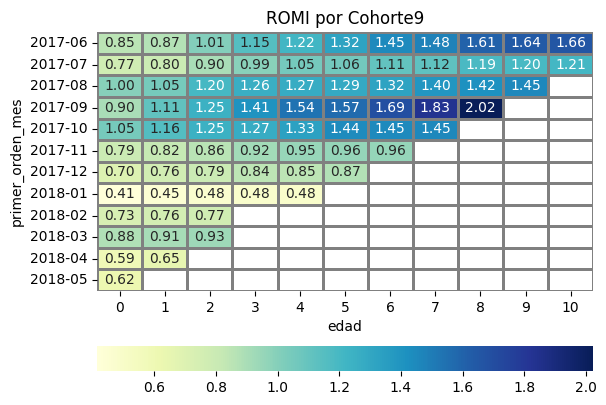

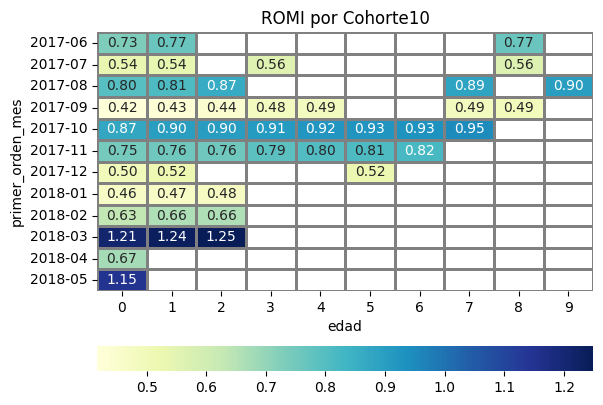

In [78]:
for source, df in compradores.groupby('source_id'):
  if source != 7:
    cohort_size = df.groupby(['source_id', 'primer_orden_mes']).agg({'uid':'nunique'}).reset_index()
    cohort_size.columns = ['source_id', 'primer_orden_mes', 'n_compradores']

    cohort_ingreso = df.groupby(['source_id', 'primer_orden_mes', 'orden_mes']).agg({'ingreso':'sum'}).reset_index()
    cohort_ingreso.columns = ['source_id', 'primer_orden_mes', 'orden_mes', 'ingreso_mes']

    romi = pd.merge(cohort_size, cohort_ingreso, on=['source_id', 'primer_orden_mes'])

    romi['edad'] = (romi['orden_mes'] - romi['primer_orden_mes']).apply(lambda x: x.n)

    romi['edad'] = romi['edad'].round(2).astype('int')

    romi['ltv'] = romi['ingreso_mes'] / romi['n_compradores']

    report_romi = pd.merge(romi, costs.groupby(['source_id', 'dt_month' ]).agg({'costs':'sum'}).reset_index(),
                           left_on=['source_id', 'primer_orden_mes'], right_on=['source_id', 'dt_month'])

    report_romi = report_romi.drop(['dt_month'], axis=1)

    report_romi['cac'] = report_romi['costs'] / report_romi['n_compradores']

    report_romi['romi'] = (report_romi['ltv'] / report_romi['cac'])

    romi_plot = report_romi.pivot_table(index='primer_orden_mes', columns='edad', values='romi', aggfunc='mean')\
               .cumsum(axis=1)

    romi_plot.round(2).fillna('')

    romi_plot.index = romi_plot.index.astype(str)

    sns.heatmap(romi_plot, annot=True, fmt=".2f", cmap="YlGnBu", linewidths=1, linecolor='grey', cbar_kws={'orientation':'horizontal'}
                ).set(title='ROMI por Cohorte{}'.format(source))

    plt.show()





La fuente 1 tiene sin lugar a duda el mejor retorno de inversión, y la fuente 3 al parecer es demasiado costosa para el poco retorno de inversión que genera, valdría la pena descontinuarlo pues no parece cubrir el costo de adquisición., de recomendar 3 fuentes por cohortes serían la 1, la 9 y la 2, quizá la 5 pudiera reinovarse, tuvo buenos momentos en 2017 pero parece haber perdido el interés de los clientes, la 4 no parece ser tan buena inversión, la 10 es muy inestable y la 3 en un año no logró el retorno de inversión en ningún cohorte.